In [92]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
from PIL import Image

from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML
import pickle
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.layers import Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model

from mtcnn.mtcnn import MTCNN
# print version

import cv2
import copy

from tqdm import tqdm
import glob

In [93]:
augmented_images_df = pd.read_pickle('aug_df_2.pkl')

In [94]:
augmented_images_df = augmented_images_df.sample(frac=1)

In [95]:
use_reduced = input('Do you want to use a reduced data-set? (Enter 0 or 1) ')
print(use_reduced)


Do you want to use a reduced data-set? (Enter 0 or 1) 0
0


In [96]:
if(use_reduced == 1): 
    num_samples = 5000
    augmented_images_df = augmented_images_df.iloc[:num_samples]
else:
    augmented_images_df = augmented_images_df.iloc[:]
    


In [97]:
X_rec_origin, y_rec_origin = augmented_images_df[['all_images', 'crop_original_image', 'neutralised_image']], augmented_images_df['name']

X_rec_origin_train, X_rec_origin_test, y_rec_origin_train, y_rec_origin_test = train_test_split(X_rec_origin, y_rec_origin, test_size=0.33, random_state=42)
X_rec_origin_train.reset_index(drop=True, inplace=True), X_rec_origin_test.reset_index(drop=True, inplace=True)
y_rec_origin_train.reset_index(drop=True, inplace=True), y_rec_origin_test.reset_index(drop=True, inplace=True)
X_rec_origin_train.shape, X_rec_origin_test.shape, y_rec_origin_train.shape, y_rec_origin_test.shape

((7873, 3), (3879, 3), (7873,), (3879,))

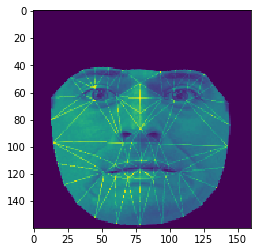

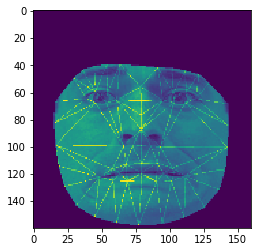

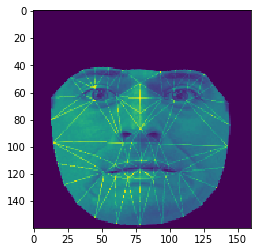

In [98]:
for i in ['all_images', 'crop_original_image', 'neutralised_image']:
    plt.imshow(X_rec_origin_train.iloc[220][i])
    plt.show()

In [99]:
X_rec_origin_train['all_images'][0].shape

(160, 160)

# Pre-process images for FaceNet

In [100]:
def preprocess_images(gray,required_size=(160, 160)):
    ''' function to pre-process images for FaceNet '''
    
    
    image = Image.fromarray(gray)
    image = image.resize(required_size)
    image = image.convert('RGB')
    face_array = np.asarray(image)
    return face_array

In [101]:
for i in tqdm(range(X_rec_origin_train.shape[0]),desc = "Pre-processing images in training set for using FaceNet"):
    
    temp_im = preprocess_images(X_rec_origin_train['all_images'][i])
    X_rec_origin_train.at[i, 'all_images'] = temp_im
    
    temp_im2 = preprocess_images(X_rec_origin_train['crop_original_image'][i])
    X_rec_origin_train.at[i, 'crop_original_image'] = temp_im2
    
    temp_im3 = preprocess_images(X_rec_origin_train['neutralised_image'][i])
    X_rec_origin_train.at[i, 'neutralised_image'] = temp_im3

Pre-processing images in training set for using FaceNet: 100%|████████████████████| 7873/7873 [00:12<00:00, 623.54it/s]


In [102]:
for i in tqdm(range(X_rec_origin_test.shape[0]),desc = "Pre-processing images in test set for using FaceNet"):
    
    temp_im = preprocess_images(X_rec_origin_test['all_images'][i])
    X_rec_origin_test.at[i, 'all_images'] = temp_im
    
    temp_im2 = preprocess_images(X_rec_origin_test['crop_original_image'][i])
    X_rec_origin_test.at[i, 'crop_original_image'] = temp_im2
    
    temp_im3 = preprocess_images(X_rec_origin_test['neutralised_image'][i])
    X_rec_origin_test.at[i, 'neutralised_image'] = temp_im3

Pre-processing images in test set for using FaceNet: 100%|████████████████████████| 3879/3879 [00:07<00:00, 553.81it/s]


(160, 160, 3)


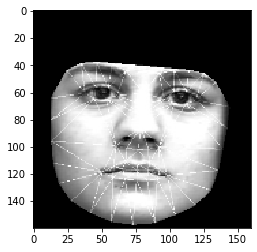

(160, 160, 3)


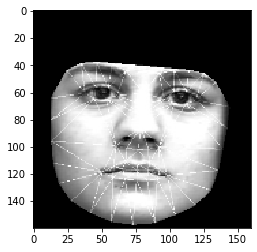

(160, 160, 3)


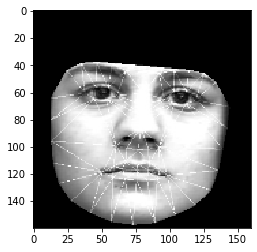

In [103]:
for i in ['all_images', 'crop_original_image', 'neutralised_image']:
    plt.imshow(X_rec_origin_train.iloc[1][i])
    print(X_rec_origin_train.iloc[1][i].shape)
    plt.show()

# Generate embeddings for the faces

In [104]:

model = load_model('..\\Data\\Model\\model\\facenet_keras.h5')

print(model.inputs)
print(model.outputs)


C:\Users\anan2\Anaconda3\envs\test\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[<tf.Tensor 'input_1_2:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_2/cond/Merge:0' shape=(?, 128) dtype=float32>]


In [105]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [106]:
X_rec_origin_train.columns

Index(['all_images', 'crop_original_image', 'neutralised_image'], dtype='object')

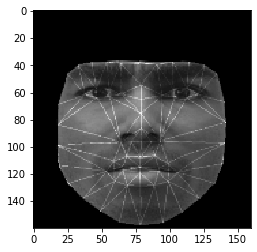

In [107]:
plt.imshow(X_rec_origin_train.iloc[100,0])

In [108]:
# convert each face in the train set to an embedding
newTrainX = list()
for i in tqdm(range(X_rec_origin_train.shape[0]),desc = "Converting images in training set to embeddings using FaceNet"):
    face_pixels = X_rec_origin_train.iloc[i,0]
    embedding = get_embedding(model, face_pixels)
    
    newTrainX.append(embedding)


Converting images in training set to embeddings using FaceNet: 100%|███████████████| 7873/7873 [12:35<00:00, 10.42it/s]


In [109]:
X_rec_origin_train = X_rec_origin_train.assign(all_images_embeddings = newTrainX)

In [110]:
# convert each face in the test set to an embedding
newTestX = list()
for i in tqdm(range(X_rec_origin_test.shape[0]),desc = "Converting images in test set to embeddings using FaceNet"):
    face_pixels = X_rec_origin_test.iloc[i,0]
    embedding = get_embedding(model, face_pixels)
    
    newTestX.append(embedding)


Converting images in test set to embeddings using FaceNet: 100%|███████████████████| 3879/3879 [06:01<00:00, 10.74it/s]


In [111]:
X_rec_origin_test = X_rec_origin_test.assign(all_images_embeddings = newTestX)

In [112]:
X_rec_origin_test.columns


Index(['all_images', 'crop_original_image', 'neutralised_image',
       'all_images_embeddings'],
      dtype='object')

In [113]:
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

(7873, 128)


In [114]:
newTestX = np.asarray(newTestX)
print(newTestX.shape)

(3879, 128)


# Train an SVM to do the recognition

In [115]:
# load necessary libraries
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot


In [116]:
lab_train = (y_rec_origin_train.values).astype(str)
lab_train

array(['503', '61', '101', ..., '14', '26', '71'], dtype='<U3')

In [117]:
lab_test = (y_rec_origin_test.values).astype(str)
lab_test

array(['160', '130', '501', ..., '78', '501', '506'], dtype='<U3')

In [118]:
print(type(lab_train),type(lab_test),sep = '\n')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [119]:
# load faces

testX_faces = X_rec_origin_test['all_images']
# load face embeddings
trainX, trainy, testX, testy = newTrainX, lab_train, newTestX, lab_test
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)


# fit model
model_SVM = SVC(gamma=2, C=1, probability=True) #SVM with RBF Kernel
model_SVM.fit(trainX, trainy)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [120]:
trainX.shape

(7873, 128)

## Performance evaluation

In [121]:
# prediction vector for the test set
yhat_accuracy = model_SVM.score(testX, testy)
print("Accuracy on test set = "+str(yhat_accuracy*100) + " %")

Accuracy on test set = 100.0 %


In [122]:
y_pred_tps = model_SVM.predict(testX)
c_mat_val = confusion_matrix(testy, y_pred_tps)
c_mat_val

array([[33,  0,  0, ...,  0,  0,  0],
       [ 0, 33,  0, ...,  0,  0,  0],
       [ 0,  0, 14, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 13,  0,  0],
       [ 0,  0,  0, ...,  0, 30,  0],
       [ 0,  0,  0, ...,  0,  0, 50]], dtype=int64)

In [123]:
print(classification_report(testy, y_pred_tps))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        42
           8       1.00      1.00      1.00        28
           9       1.00      1.00      1.00        61
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        25
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00        35
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        29
          17       1.00    

Predicted: 52 (50.905 %)
Expected: 52


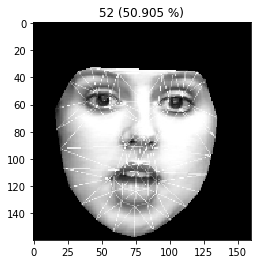

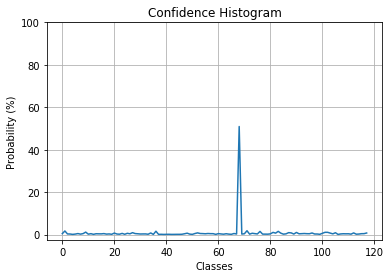

Predicted: 52 (39.499 %)
Expected: 52


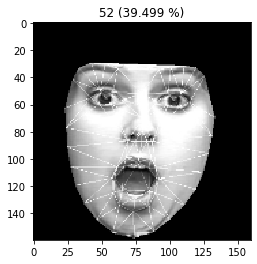

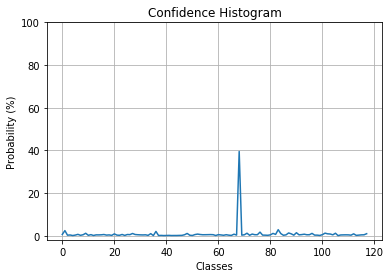

Predicted: 52 (48.698 %)
Expected: 52


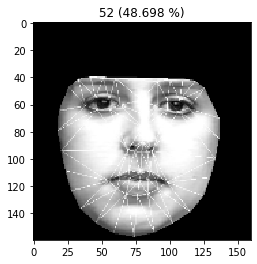

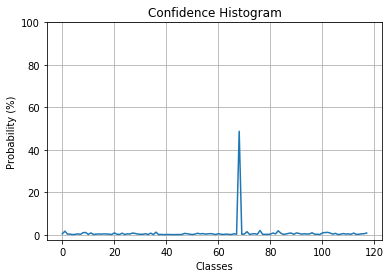

Predicted: 52 (44.992 %)
Expected: 52


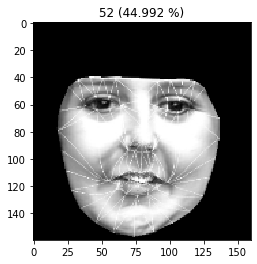

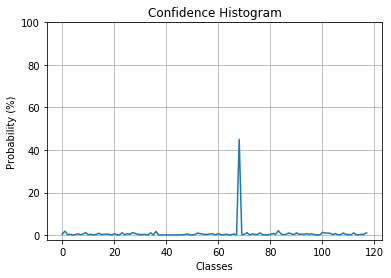

Predicted: 52 (48.443 %)
Expected: 52


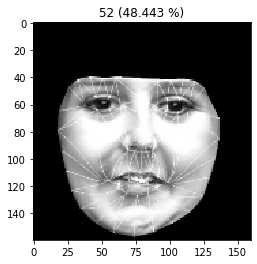

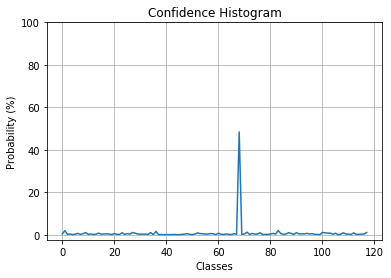

Predicted: 52 (56.323 %)
Expected: 52


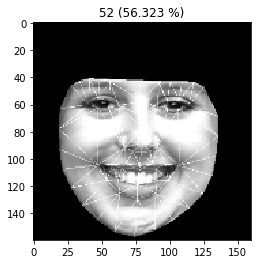

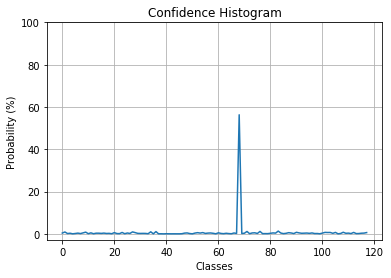

Predicted: 52 (49.312 %)
Expected: 52


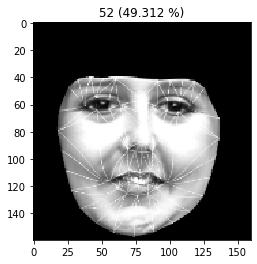

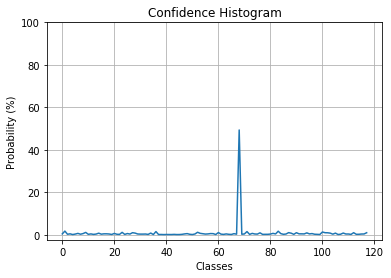

Predicted: 52 (50.697 %)
Expected: 52


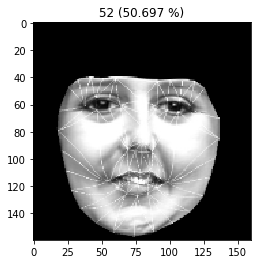

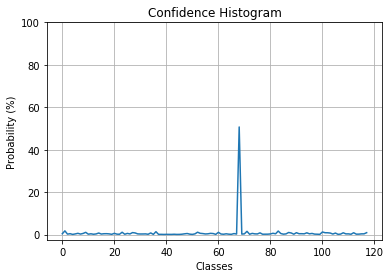

Predicted: 52 (50.769 %)
Expected: 52


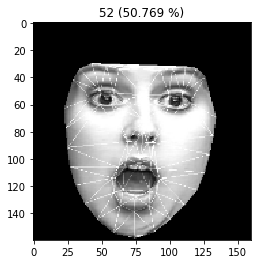

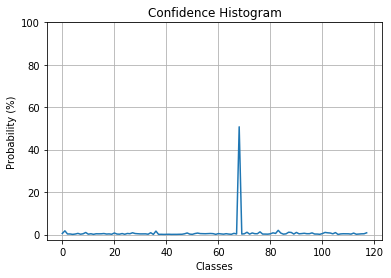

Predicted: 52 (49.543 %)
Expected: 52


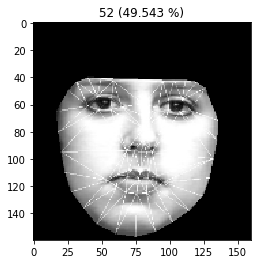

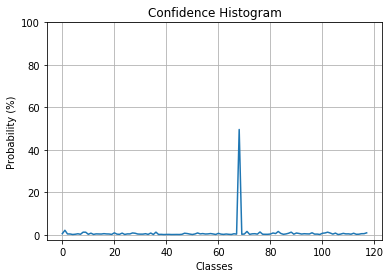

Predicted: 52 (51.310 %)
Expected: 52


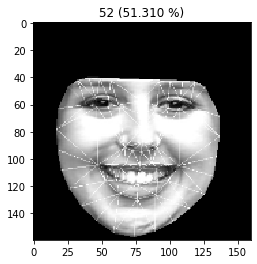

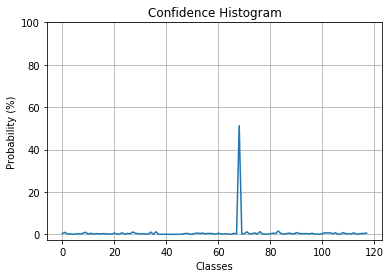

Predicted: 52 (51.024 %)
Expected: 52


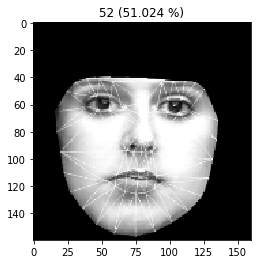

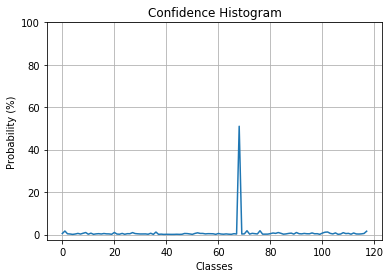

Predicted: 52 (52.992 %)
Expected: 52


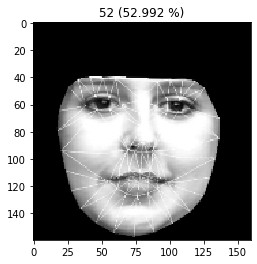

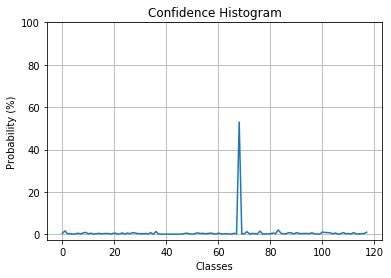

Predicted: 52 (55.276 %)
Expected: 52


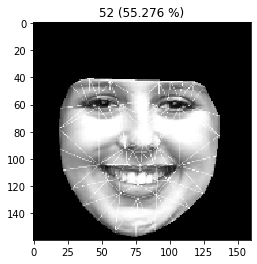

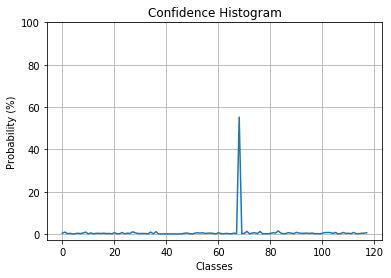

Predicted: 52 (46.734 %)
Expected: 52


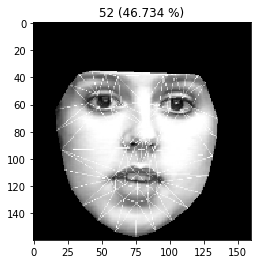

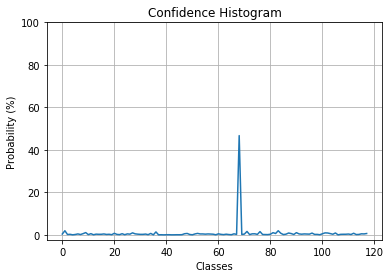

Predicted: 52 (53.649 %)
Expected: 52


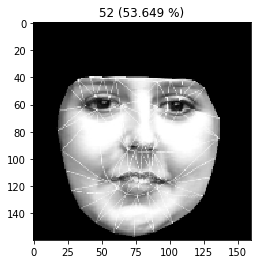

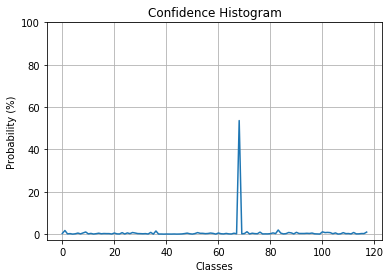

Predicted: 52 (46.230 %)
Expected: 52


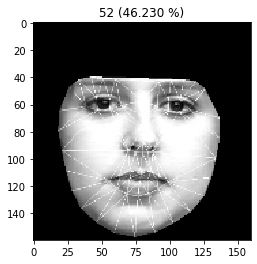

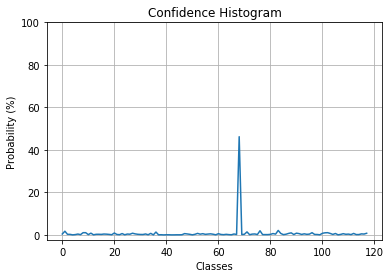

Predicted: 52 (47.574 %)
Expected: 52


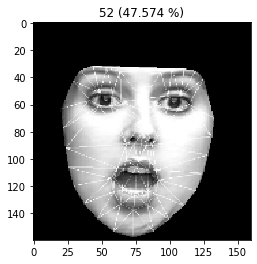

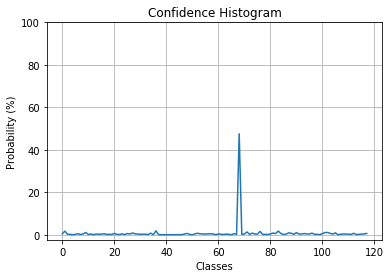

Predicted: 52 (43.776 %)
Expected: 52


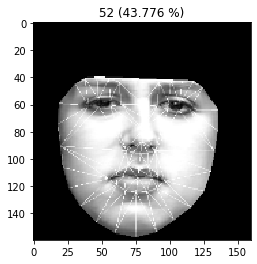

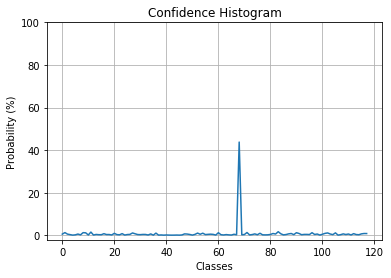

Predicted: 52 (48.664 %)
Expected: 52


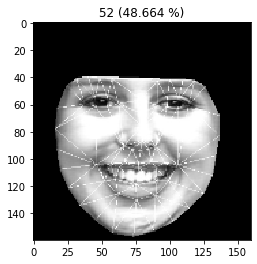

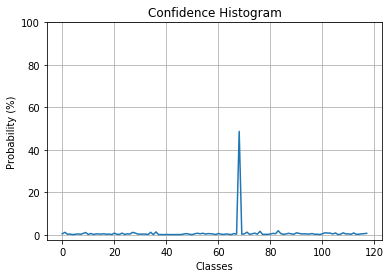

Predicted: 52 (47.861 %)
Expected: 52


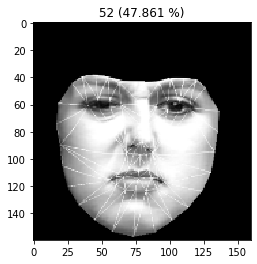

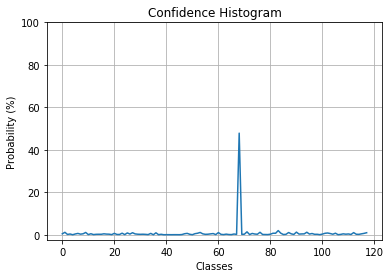

Predicted: 52 (53.632 %)
Expected: 52


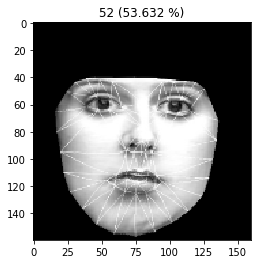

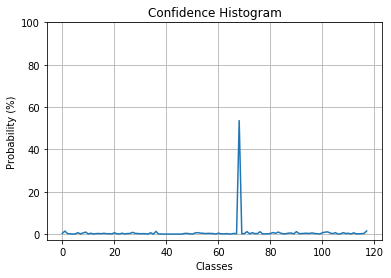

Predicted: 52 (49.712 %)
Expected: 52


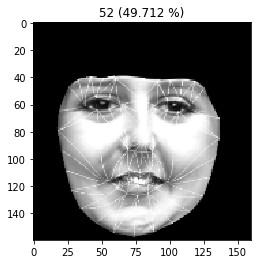

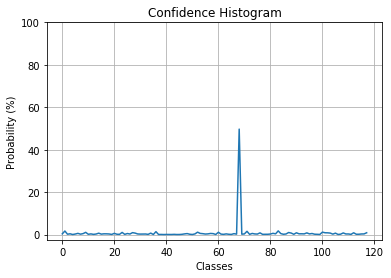

Predicted: 52 (51.971 %)
Expected: 52


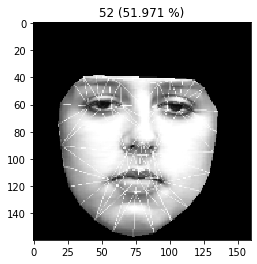

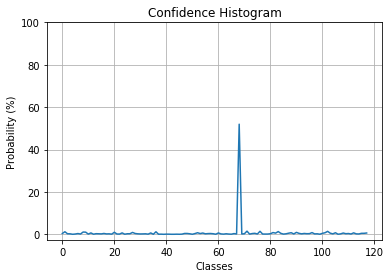

Predicted: 52 (47.319 %)
Expected: 52


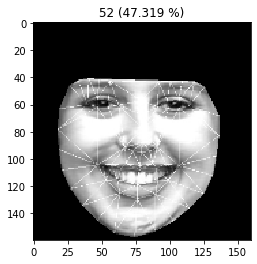

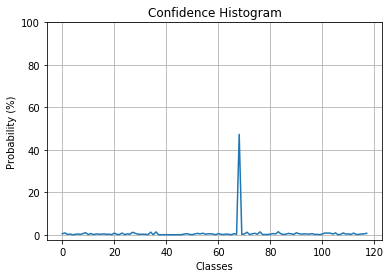

Predicted: 52 (54.359 %)
Expected: 52


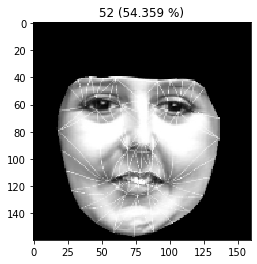

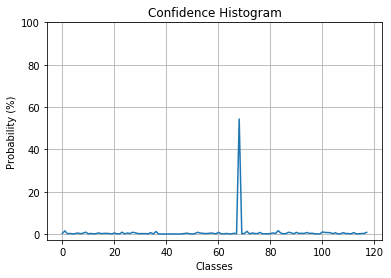

Predicted: 52 (52.436 %)
Expected: 52


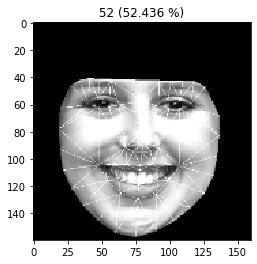

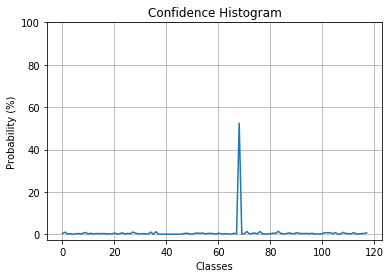

Predicted: 52 (50.372 %)
Expected: 52


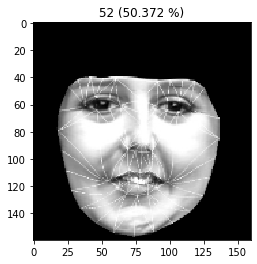

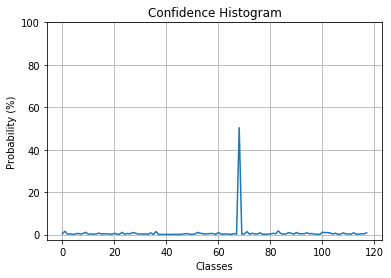

Predicted: 52 (63.572 %)
Expected: 52


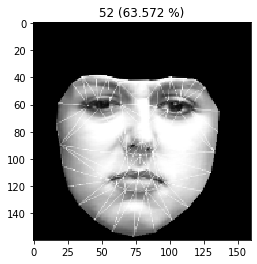

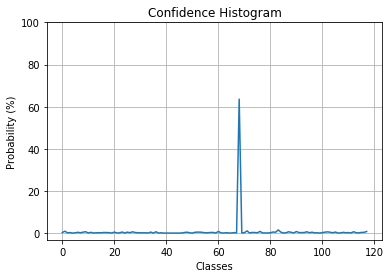

Predicted: 52 (46.154 %)
Expected: 52


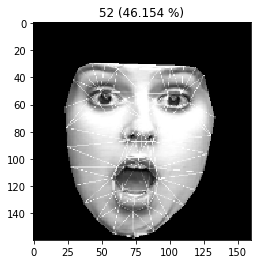

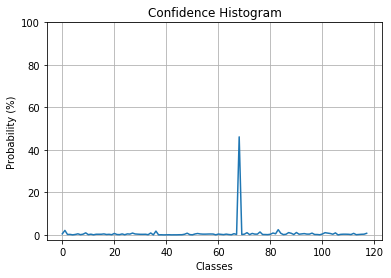

Predicted: 52 (48.698 %)
Expected: 52


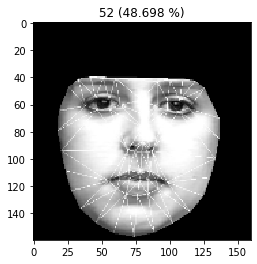

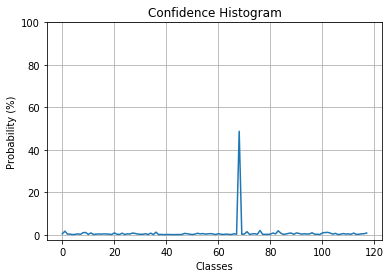

Predicted: 52 (42.872 %)
Expected: 52


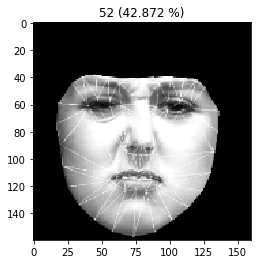

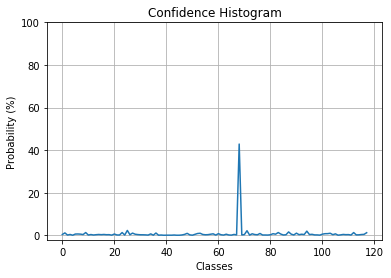

Predicted: 52 (55.979 %)
Expected: 52


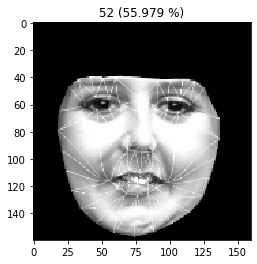

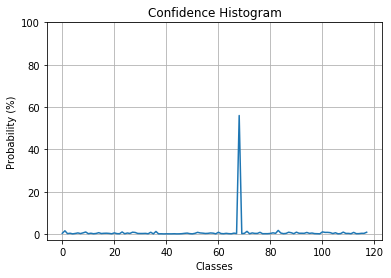

Predicted: 52 (54.908 %)
Expected: 52


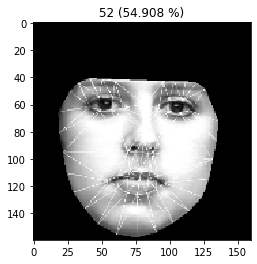

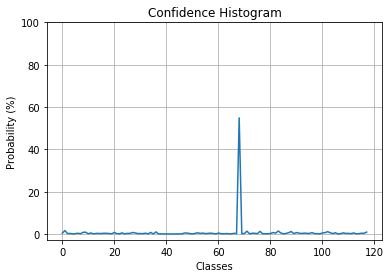

Predicted: 52 (55.040 %)
Expected: 52


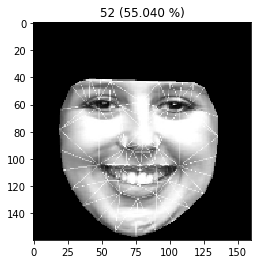

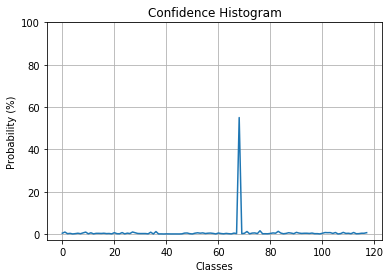

Predicted: 52 (53.599 %)
Expected: 52


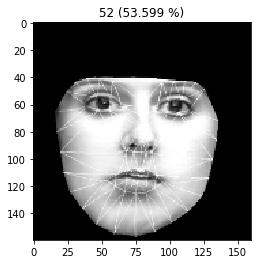

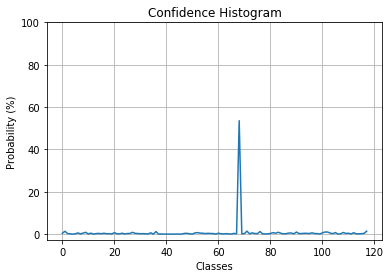

Predicted: 52 (47.132 %)
Expected: 52


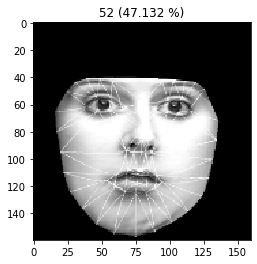

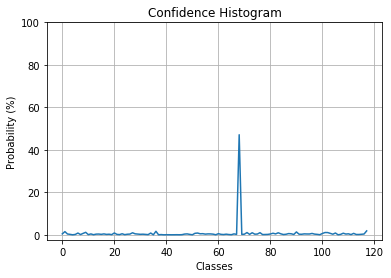

Predicted: 52 (55.909 %)
Expected: 52


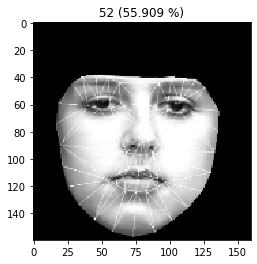

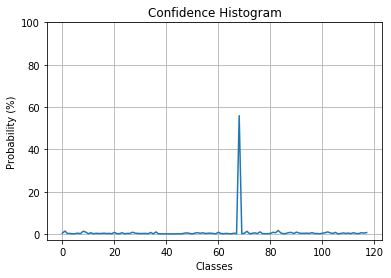

Predicted: 52 (48.477 %)
Expected: 52


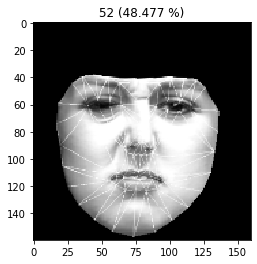

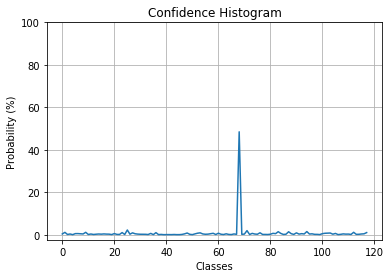

Predicted: 52 (52.605 %)
Expected: 52


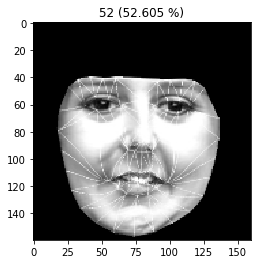

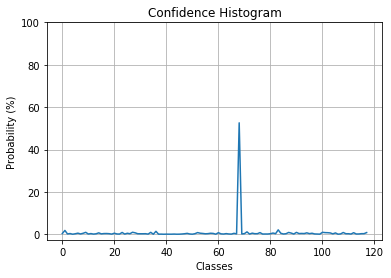

In [124]:
facenet_confidences_original = []
facenet_confidences_neutralised = []

for ind in range(testX.shape[0]):
    # test model on a random example from the test dataset
    selection = ind
    
    random_face_pixels = X_rec_origin_test.iloc[selection,0]
    random_face_emb = testX[selection]
    random_face_class = testy[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])
    # prediction for the face
    samples = expand_dims(random_face_emb, axis=0)
    yhat_class = model_SVM.predict(samples)
    
    yhat_prob = model_SVM.predict_proba(samples)
    
    
        
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    
    if np.array_equal(random_face_pixels , X_rec_origin_test['crop_original_image'][selection]):
        facenet_confidences_original.append(class_probability)
    elif np.array_equal(random_face_pixels , X_rec_origin_test['neutralised_image'][selection]):
        facenet_confidences_neutralised.append(class_probability)
    else:
        pass #should never happen
    
    predict_names = out_encoder.inverse_transform(yhat_class)
    if(predict_names[0] == '52'):
        print('Predicted: %s (%.3f %%)' % (predict_names[0], class_probability))
        print('Expected: %s' % random_face_name[0])
       
        # plot for fun
        pyplot.imshow(random_face_pixels)
        title = '%s (%.3f %%)' % (predict_names[0], class_probability)
        pyplot.title(title)


        pyplot.show()
        pyplot.plot(yhat_prob.flatten() * 100)
        x1,x2,y1,y2 = plt.axis()

        plt.axis((x1,x2,y1,100))
        pyplot.ylabel("Probability (%)")
        pyplot.xlabel("Classes")
        pyplot.title("Confidence Histogram")
        pyplot.grid()

        pyplot.show()

## Plotting the Cumulative histogram

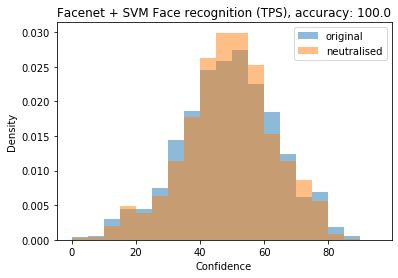

In [125]:
density_param = True
plt.hist(facenet_confidences_original, density = density_param, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(facenet_confidences_neutralised, density = density_param, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('Facenet + SVM Face recognition (TPS), accuracy: {}'.format(yhat_accuracy*100))
plt.savefig('Facenet_TPS_Facerecognition.png')
plt.legend()